In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dense, Input, Lambda
from keras.optimizers import Adam, Adamax, RMSprop, Adagrad
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications import ResNet50V2, InceptionV3

In [ ]:
def lenet5(opt, conv1_fs, conv2_fs, act, avg_pool):
    
    model = keras.Sequential()
        
    model.add(Conv2D(filters=conv1_fs, kernel_size=(5,5), padding='same', 
                     activation=act, input_shape=(28, 28, 1)))
    if avg_pool:
        model.add(AveragePooling2D(strides=2))
    else:
        model.add(MaxPool2D(strides=2))
    
    model.add(Conv2D(filters=conv2_fs, kernel_size=(5,5), padding='valid', 
                     activation=act))
    if avg_pool:
        model.add(AveragePooling2D(strides=2))
    else:
        model.add(MaxPool2D(strides=2))              
        
    model.add(Flatten())
    
    model.add(Dense(256, activation=act))
    
    model.add(Dense(84, activation=act))
    
    model.add(Dense(10, activation='softmax'))
    
    
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
def cp_ResNet50V2():
    model = ResNet50V2(include_top=False, input_shape=(224,224,3), weights='imagenet')
    
    newInput = Input(batch_shape=(None, 28, 28, 3))
    resizedImg = Lambda(lambda image: tf.image.resize(image, (224,224)))(newInput)
    newOutputs = model(resizedImg)
    model = Model(newInput, newOutputs)
    # Freeze dense layers
    for layer in model.layers[:]:
        layer.trainable = False
        
    output = model.output
    output = Flatten()(output)
    output = Dense(128, activation='tanh')(output)
    output = Dense(64, activation='tanh')(output)
    output = Dense(units=10, activation='softmax')(output)
    model = Model(model.input, output)
    
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    return model

In [ ]:
def cp_InceptionV3():
    model = InceptionV3(include_top=False, input_shape=(224,224,3), weights='imagenet')
    
    newInput = Input(batch_shape=(None, 28, 28, 3))
    resizedImg = Lambda(lambda image: tf.image.resize(image, (224,224)))(newInput)
    newOutputs = model(resizedImg)
    model = Model(newInput, newOutputs)
    # Freeze dense layers
    for layer in model.layers[:]:
        layer.trainable = False
        
    output = model.output
    output = Flatten()(output)
    output = Dense(128, activation='tanh')(output)
    output = Dense(64, activation='tanh')(output)
    output = Dense(units=10, activation='softmax')(output)
    model = Model(model.input, output)
    
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    return model

In [ ]:
# Load the fashion-mnist pre-shuffled train data and test data
import tensorflow as tf
import keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

In [3]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Looking at the shapes of the train and test data
train.shape, test.shape

((60000, 785), (10000, 785))

In [ ]:
# Checking null values existance
print('Number of null values in train data = ', train.isna().any().sum())
print('Number of null values in test data = ', test.isna().any().sum())

Number of null values in train data =  0
Number of null values in test data =  0


### Train data contains duplicate values

In [ ]:
# Checking for duplicate values in train data
train[train.duplicated()]

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
6293,3,0,0,0,0,0,0,0,0,57,...,22,0,0,0,0,0,0,0,0,0
11845,0,0,0,0,0,2,0,0,0,0,...,34,26,22,26,8,0,2,0,0,0
20114,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21571,0,0,0,0,0,0,0,0,0,24,...,136,99,18,0,0,0,0,0,0,0
22159,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23718,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24228,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24443,2,0,0,0,0,0,0,0,0,0,...,108,97,106,62,0,0,0,0,0,0
28184,3,0,0,0,0,0,0,0,0,0,...,48,24,0,0,0,0,0,0,0,0
28635,2,0,0,0,0,0,0,0,0,0,...,0,0,0,98,128,88,0,0,0,0


In [ ]:
# Checking for duplicate values in test data
test[test.duplicated()]

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
8569,0,0,0,0,0,0,0,0,0,51,...,70,43,21,0,0,0,0,0,0,0


In [4]:
# Shape after dropping duplicates: 60,000 - 43 = 59,957
train.drop_duplicates(inplace=True)
# Shape after dropping duplicates: 10,000 - 1 = 9,999
test.drop_duplicates(inplace=True)
train.shape, test.shape

((59957, 785), (9999, 785))

In [ ]:
# Describing the data
train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,...,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000,59957.000000
mean,4.500409,0.000901,0.006154,0.035342,0.102006,0.248094,0.411762,0.805744,2.197325,5.677802,...,34.620695,23.294528,16.581634,17.846190,22.799039,17.908901,8.523859,2.755275,0.856130,0.070300
std,2.872572,0.094723,0.271108,1.222756,2.453749,4.308444,5.838271,8.217037,14.090882,23.816347,...,57.546358,48.852671,41.974171,43.933567,51.815466,45.152503,29.622113,17.403733,9.360287,2.126631
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.000000


In [5]:
# Splitting the data into train and test 
X_train = train.drop('label', axis=1).to_numpy()
y_train = train.label
X_test = test.drop('label', axis=1).to_numpy()
y_test = test.label
X_train.shape, X_test.shape

((59957, 784), (9999, 784))

In [8]:
# Normalizing the data 
X_train_norm = X_train/255
X_test_norm = X_test/255

In [6]:
# Reshaping the images to be 2-D (28 × 28)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train.shape, X_test.shape

((59957, 28, 28, 1), (9999, 28, 28, 1))

In [9]:
# Reshaping the images to be 2-D (28 × 28)
X_train_norm = X_train_norm.reshape(X_train_norm.shape[0], 28, 28, 1)
X_test_norm = X_test_norm.reshape(X_test_norm.shape[0], 28, 28, 1)
X_test_norm.shape, X_test_norm.shape

((9999, 28, 28, 1), (9999, 28, 28, 1))

## Drawing some of the images

In [10]:
# Creating a dictionary for labels
labels_decoded = {0: 'T-shirt/top',
                 1: 'Trouser',
                 2: 'Pullover',
                 3: 'Dress',
                 4: 'Coat',
                 5: 'Sandal',
                 6: 'Shirt',
                 7: 'Sneaker',
                 8: 'Bag',
                 9: 'Ankle boot',
                 }

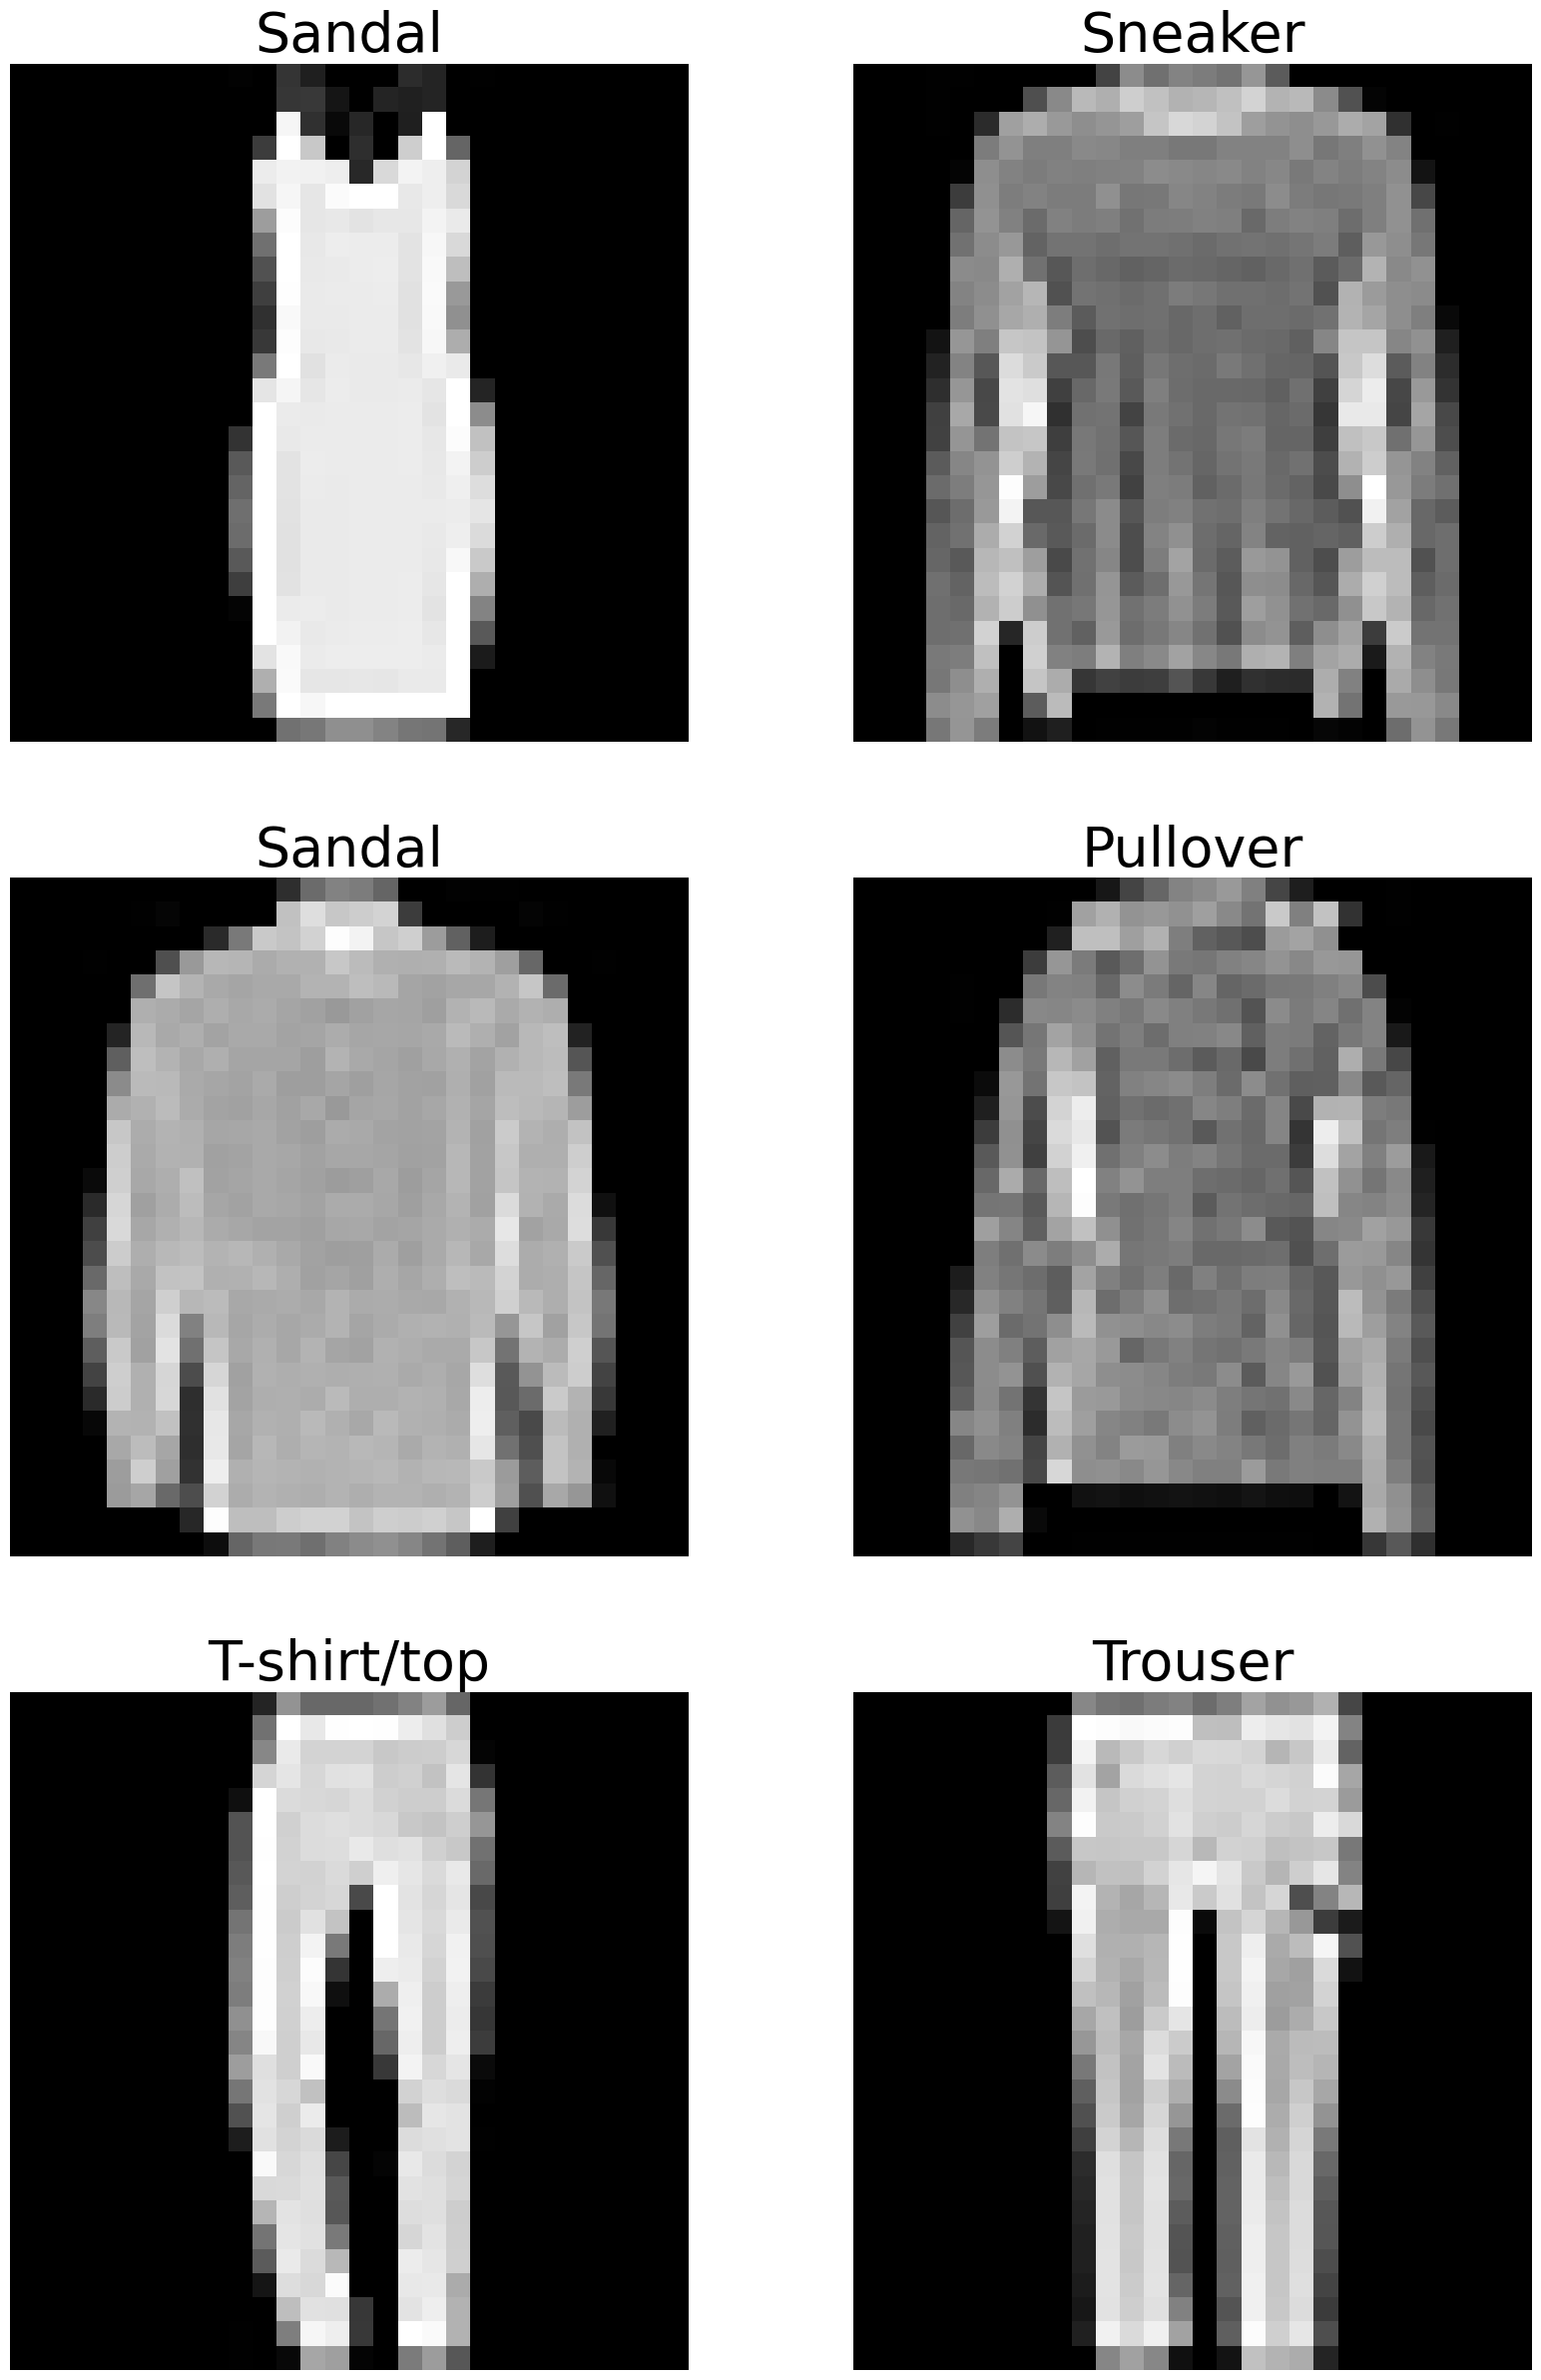

In [11]:
plt.figure(figsize=(20,30))
for i in range(6):
    idx=np.random.choice(range(len(X_train)))
    img = X_train[idx]
    plt.subplot(3,2,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(labels_decoded[y_train[idx]],
          fontsize = 40)
    plt.axis('off')
plt.show()

## Plotting some of the images' histogram

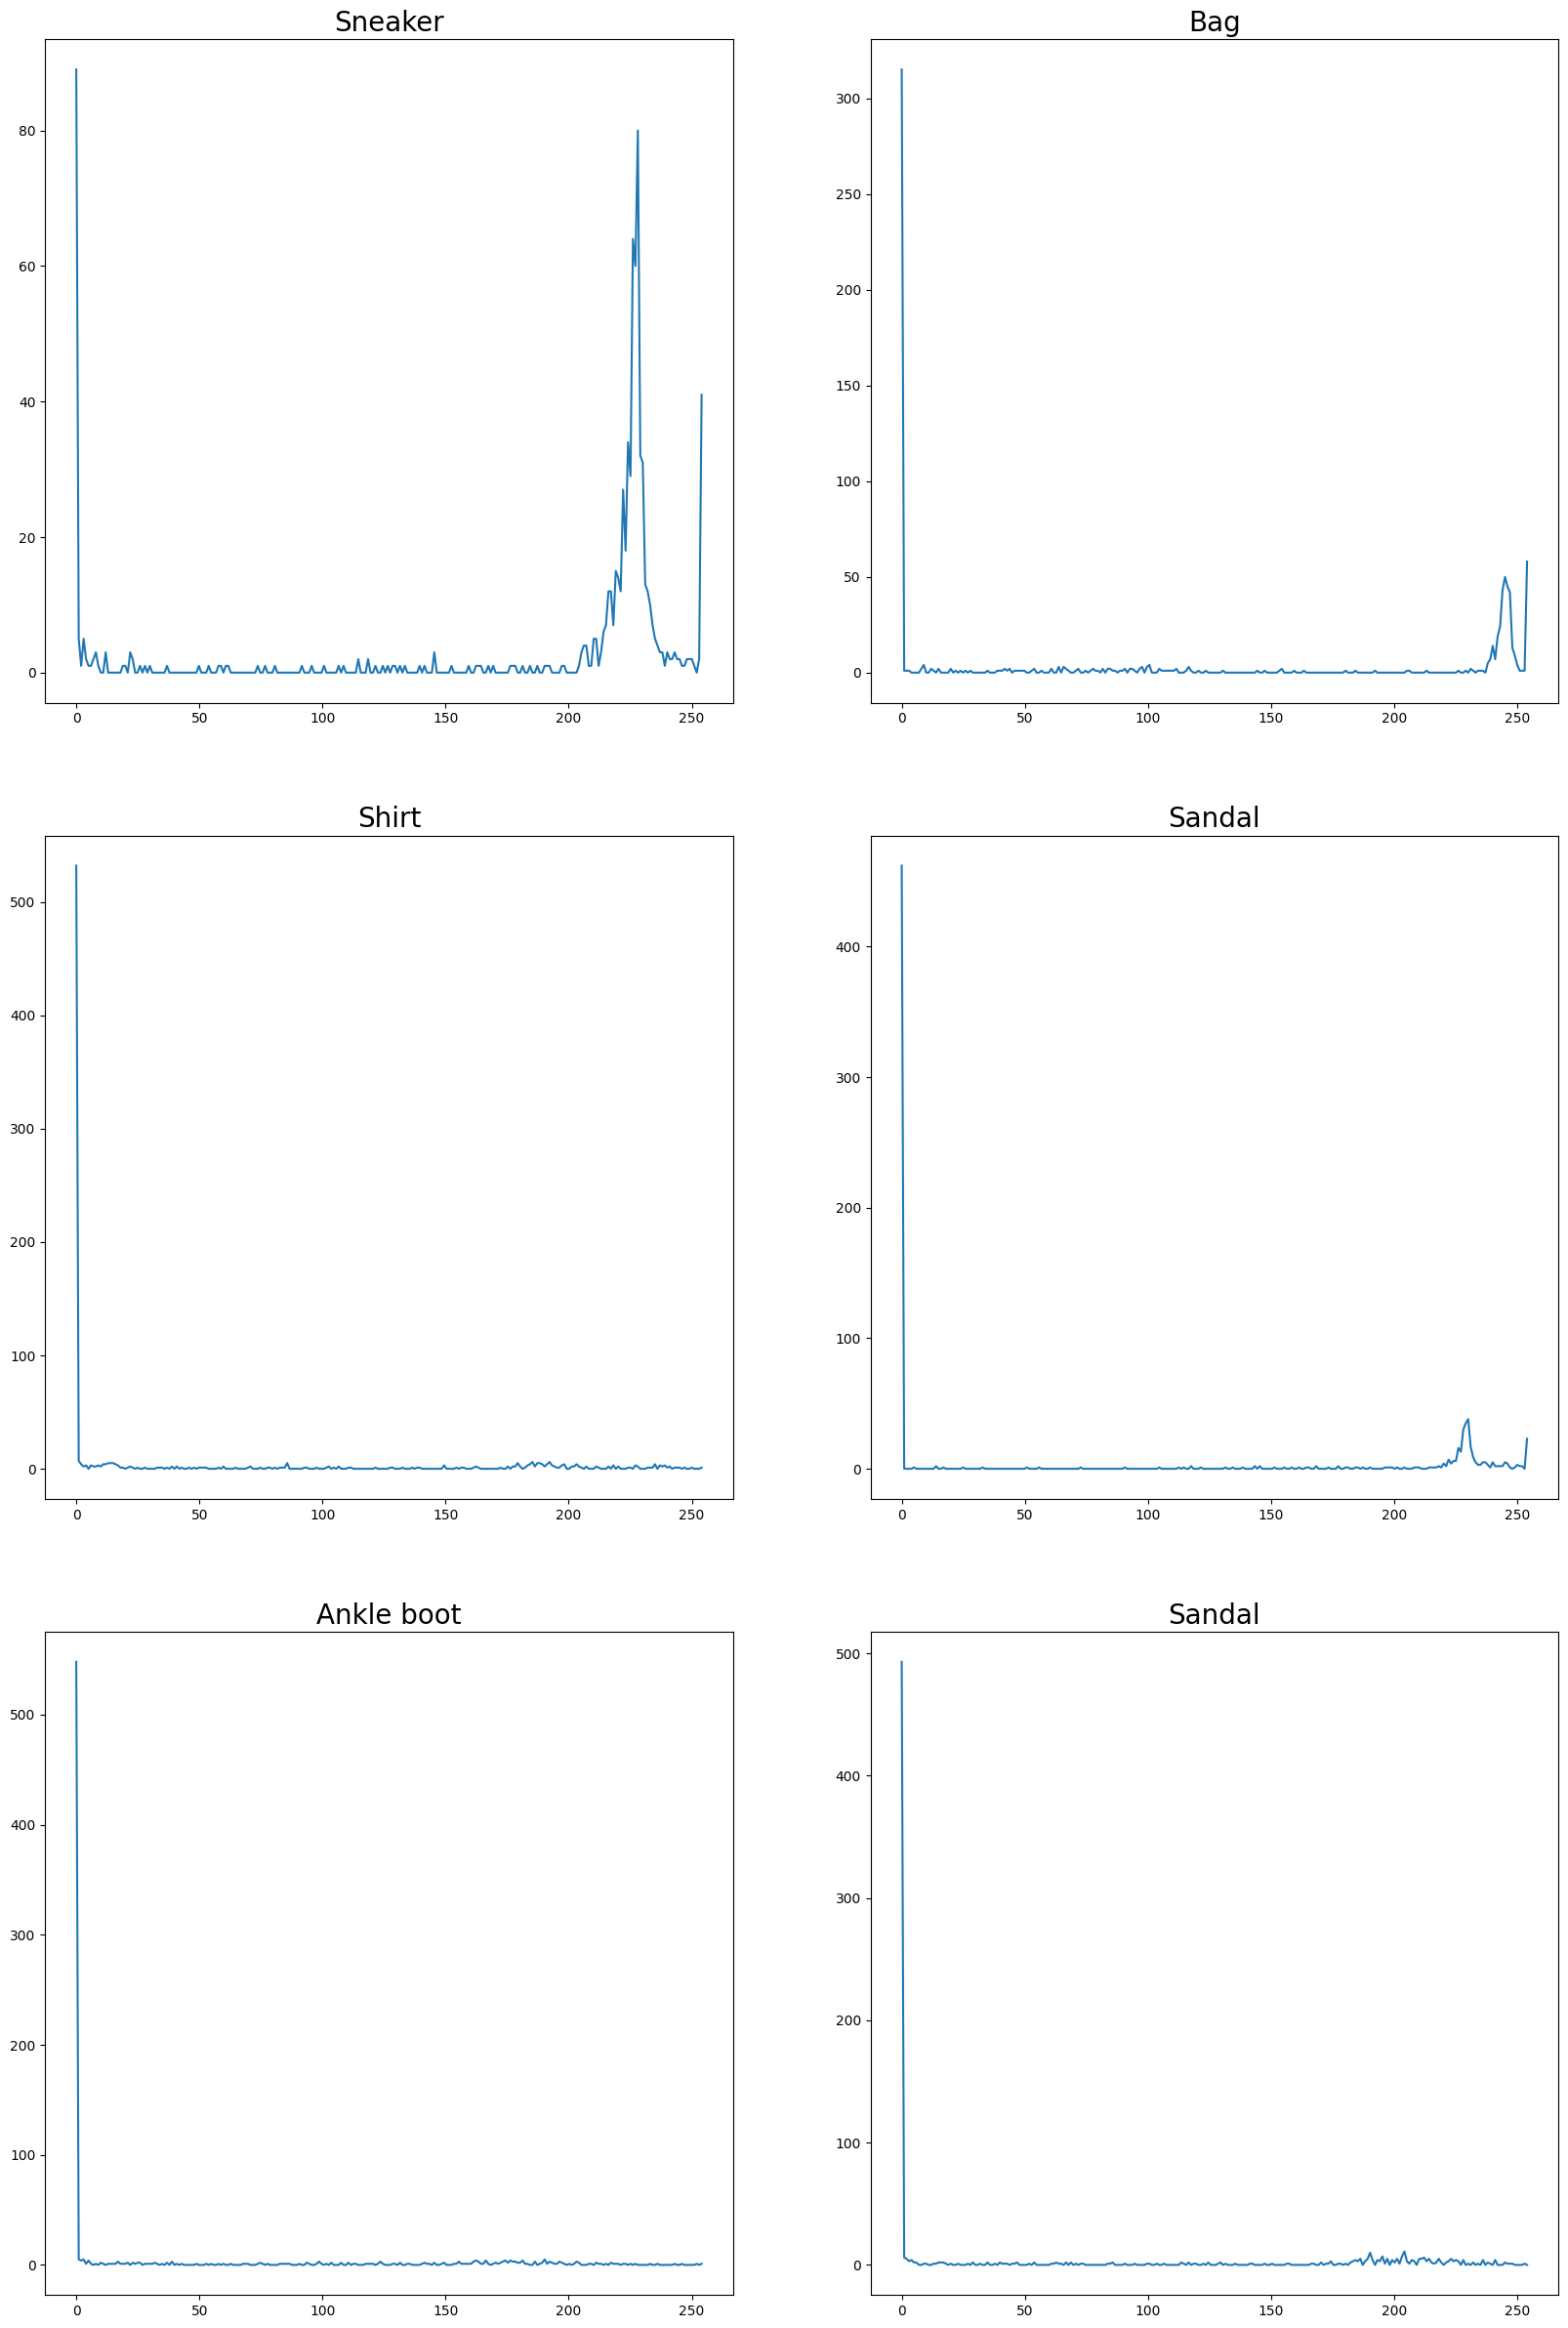

In [12]:
plt.figure(figsize=(20,30))
for i in range(6):
    idx=np.random.choice(range(len(X_train)))
    img = X_train[idx]
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    plt.subplot(3,2,i+1)
    plt.plot(bin_edges[0:-1], histogram)
    plt.title(labels_decoded[y_train[idx]],
          fontsize = 20)
plt.show()

# LeNet5

In [ ]:
optims = {'Adam': Adam, 'Adamax': Adamax, 'Adagrad': Adagrad}
lern_rates = [0.001, 0.005]
conv1 = [32, 6]
conv2 = [48, 16]
activations = ['relu', 'tanh']
avg_pool = [True, False]
hyperparam_tune = pd.DataFrame()
kf = KFold(n_splits=5)
reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', 
    patience=5, 
    verbose=0, 
    factor=0.5, 
    min_lr=1e-6) 

early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0, 
    patience=5, 
    verbose=0,
    mode="auto") 

for name, opt in optims.items():
    for lr in lern_rates[:1]:
        for c1 in conv1:
            for c2 in conv2:
                for act in activations:
                    for avg in avg_pool:
                        optim = opt(learning_rate=lr)
                        print('Optimizer = ', name,
                              'Learning_Rate = ', lr,
                              'Conv1 = ', c1,
                              'Conv2 = ', c2,
                              'Activation = ', act,
                              'Average_Pooling = ', avg)
                        model = lenet5(optim, c1, c2, act, avg)
                        loss = []
                        acc = []
                        for (train_index, val_index) in kf.split(X_train_norm):
                            X_train_k = X_train[train_index]
                            y_train_k = y_train.iloc[train_index]
                            X_val = X_train[val_index]
                            y_val = y_train.iloc[val_index]
                            history = model.fit(X_train_k, y_train_k, batch_size = 2048,
                                     epochs = 100, validation_data=(X_val, y_val),
                                               callbacks=[reduce_lr, early_stop], verbose=0)
                            score = model.evaluate(X_val, y_val)
                            loss.append(score[0])
                            acc.append(score[1])
                        print('Average loss = ', np.mean(loss),
                              'Average accuracy = ', np.mean(acc))  
                        params_score = {'Optimizer': [name],
                                  'Learning_Rate': [lr],
                                  'Conv1': [c1],
                                  'Conv2': [c2],
                                  'Activation': [act],
                                  'Average_Pooling': [avg],
                                  'Validation_Loss': [np.mean(loss)],
                                  'Validation_Accuracy': [np.mean(acc)]}
                        hyperparam_tune = pd.concat([hyperparam_tune, pd.DataFrame(params_score)], 
                                                    ignore_index=True)
hyperparam_tune.to_csv('lenet5_tune.csv', index=False)

Optimizer =  Adam Learning_Rate =  0.001 Conv1 =  32 Conv2 =  48 Activation =  relu Average_Pooling =  True
375/375 [==============================] - 1s 3ms/step - loss: 0.1541 - accuracy: 0.9440
Average loss =  0.19414931833744048 Average accuracy =  0.9286660432815552
Optimizer =  Adam Learning_Rate =  0.001 Conv1 =  32 Conv2 =  48 Activation =  relu Average_Pooling =  False
375/375 [==============================] - 1s 3ms/step - loss: 0.1069 - accuracy: 0.9616
Average loss =  0.16106384247541428 Average accuracy =  0.94167560338974
Optimizer =  Adam Learning_Rate =  0.001 Conv1 =  32 Conv2 =  48 Activation =  tanh Average_Pooling =  True
375/375 [==============================] - 1s 3ms/step - loss: 0.1108 - accuracy: 0.9620
Average loss =  0.1731225609779358 Average accuracy =  0.9377061128616333
Optimizer =  Adam Learning_Rate =  0.001 Conv1 =  32 Conv2 =  48 Activation =  tanh Average_Pooling =  False
375/375 [==============================] - 1s 3ms/step - loss: 0.1011 - accur

## Before trying out transfer learning, we need to have 3-D images instead of 1-D

In [ ]:
# we need 3 channel (instead of 1)
X_train_norm = np.repeat(X_train_norm, 3, axis=-1)
X_test_norm = np.repeat(X_test_norm, 3, axis=-1)
X_train_norm.shape, X_test_norm.shape

((59957, 28, 28, 3), (9999, 28, 28, 3))

# Tuning ResNet50V2

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', 
    patience=5, 
    verbose=0, 
    factor=0.5, 
    min_lr=1e-6) 

early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0, 
    patience=5, 
    verbose=0,
    mode="auto") 

model = cp_ResNet50V2()

history = model.fit(X_train_norm, y_train, batch_size = 512,
         epochs = 100, validation_data=(X_test_norm, y_test),
                   callbacks=[reduce_lr, early_stop])
score = model.evaluate(X_test_norm, y_test)
print('Test loss = ', score[0])
print('Test accuracy = ', score[1])

Epoch 1/100
118/118 [==============================] - 104s 804ms/step - loss: 0.4055 - accuracy: 0.8589 - val_loss: 0.3139 - val_accuracy: 0.8871 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 93s 792ms/step - loss: 0.3015 - accuracy: 0.8940 - val_loss: 0.3032 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 93s 792ms/step - loss: 0.2863 - accuracy: 0.8989 - val_loss: 0.2980 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 85s 720ms/step - loss: 0.2772 - accuracy: 0.9011 - val_loss: 0.3061 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 93s 791ms/step - loss: 0.2811 - accuracy: 0.8994 - val_loss: 0.2989 - val_accuracy: 0.8938 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 93s 792ms/step - loss: 0.2766 - accuracy: 0.9011 - val_loss: 0.3027 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 7/100
118/118 [========================

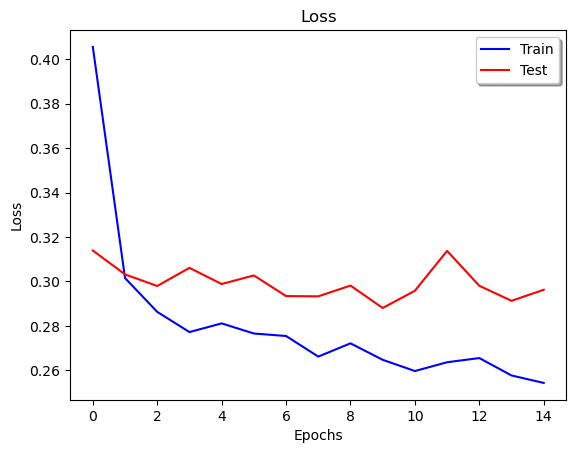

In [ ]:
# Plotting the loss
plt.plot(history.history['loss'], color='b', label="Train")
plt.plot(history.history['val_loss'], color='r', label="Test")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best', shadow=True)
plt.show()

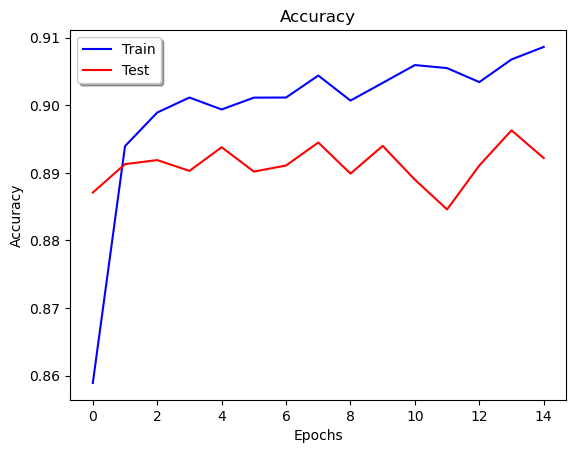

In [ ]:
# Plotting the accuracy
plt.plot(history.history['accuracy'], color='b', label="Train")
plt.plot(history.history['val_accuracy'], color='r', label="Test")
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best', shadow=True)
plt.show()

# Tuning InceptionV3

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', 
    patience=5, 
    verbose=0, 
    factor=0.5, 
    min_lr=1e-6) 

early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0, 
    patience=5, 
    verbose=0,
    mode="auto") 

model = cp_InceptionV3()

history = model.fit(X_train_norm, y_train, batch_size = 512,
         epochs = 100, validation_data=(X_test_norm, y_test),
                   callbacks=[reduce_lr, early_stop])
score = model.evaluate(X_test_norm, y_test)
print('Test loss = ', score[0])
print('Test accuracy = ', score[1])

87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/100
118/118 [==============================] - 85s 658ms/step - loss: 0.7019 - accuracy: 0.7910 - val_loss: 0.4293 - val_accuracy: 0.8547 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 65s 554ms/step - loss: 0.4146 - accuracy: 0.8591 - val_loss: 0.4096 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 65s 554ms/step - loss: 0.3811 - accuracy: 0.8696 - val_loss: 0.3772 - val_accuracy: 0.8697 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 65s 553ms/step - loss: 0.3676 - accuracy: 0.8711 - val_loss: 0.4061 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 64s 544ms/step - loss: 0.3673 - accuracy: 0.8709 - val_loss: 0.3638 - val_accuracy: 0.8736 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 64s 544ms/step - loss: 0.3561 - accuracy: 0.8762 - val_loss: 0.3812 - val_accuracy: 0

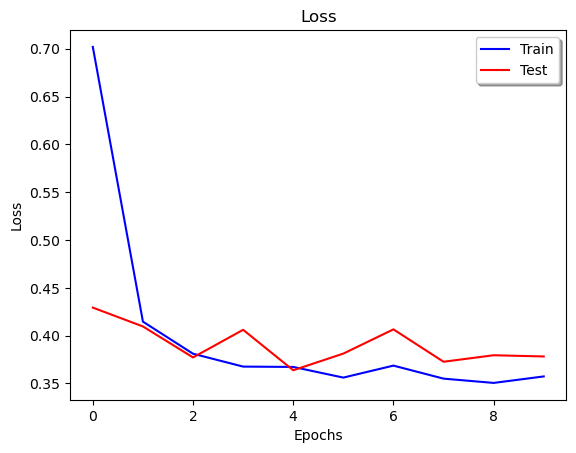

In [ ]:
# Plotting the loss
plt.plot(history.history['loss'], color='b', label="Train")
plt.plot(history.history['val_loss'], color='r', label="Test")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best', shadow=True)
plt.show()

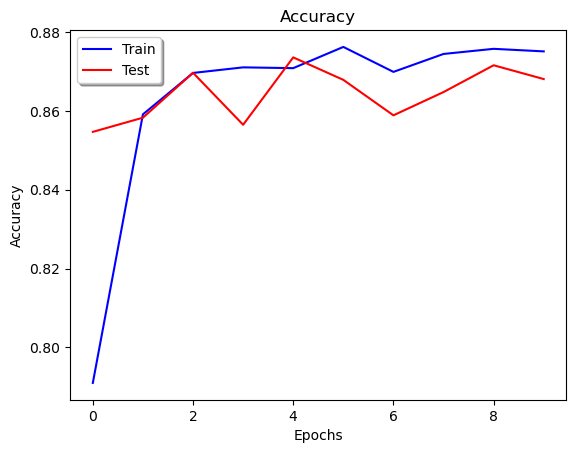

In [ ]:
# Plotting the accuracy
plt.plot(history.history['accuracy'], color='b', label="Train")
plt.plot(history.history['val_accuracy'], color='r', label="Test")
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best', shadow=True)
plt.show()

## Full Trained LeNet5 with the hyperparameters that gave the best results

In [ ]:
# Splitting the data into train and test 
X_train = train.drop('label', axis=1).to_numpy()
y_train = train.label
X_test = test.drop('label', axis=1).to_numpy()
y_test = test.label
X_train.shape, X_test.shape

((59957, 784), (9999, 784))

In [ ]:
# Normalizing the data 
X_train = X_train/255
X_test = X_test/255

In [ ]:
# Reshaping the images to be 2-D (28 × 28)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train.shape, X_test.shape

((59957, 28, 28, 1), (9999, 28, 28, 1))

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', 
    patience=5, 
    verbose=0, 
    factor=0.5, 
    min_lr=1e-6) 

early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0, 
    patience=5, 
    verbose=0,
    mode="auto") 

model = lenet5('Adam', 32, 48, 'tanh', False)

history = model.fit(X_train, y_train, batch_size = 512,
         epochs = 100, validation_data=(X_test, y_test),
                   callbacks=[reduce_lr, early_stop])
score = model.evaluate(X_test, y_test)
print('Test loss = ', score[0])
print('Test accuracy = ', score[1])

Epoch 1/100
118/118 [==============================] - 4s 12ms/step - loss: 0.6030 - accuracy: 0.7844 - val_loss: 0.4067 - val_accuracy: 0.8615 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 9ms/step - loss: 0.3757 - accuracy: 0.8655 - val_loss: 0.3655 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 9ms/step - loss: 0.3216 - accuracy: 0.8838 - val_loss: 0.2991 - val_accuracy: 0.8904 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 9ms/step - loss: 0.2908 - accuracy: 0.8948 - val_loss: 0.2902 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 10ms/step - loss: 0.2684 - accuracy: 0.9023 - val_loss: 0.2772 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 9ms/step - loss: 0.2455 - accuracy: 0.9111 - val_loss: 0.2883 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 1s 9ms/

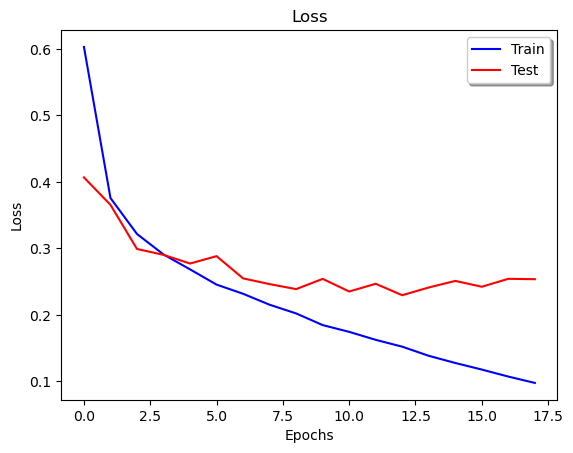

In [ ]:
# Plotting the loss
plt.plot(history.history['loss'], color='b', label="Train")
plt.plot(history.history['val_loss'], color='r', label="Test")
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best', shadow=True)
plt.show()

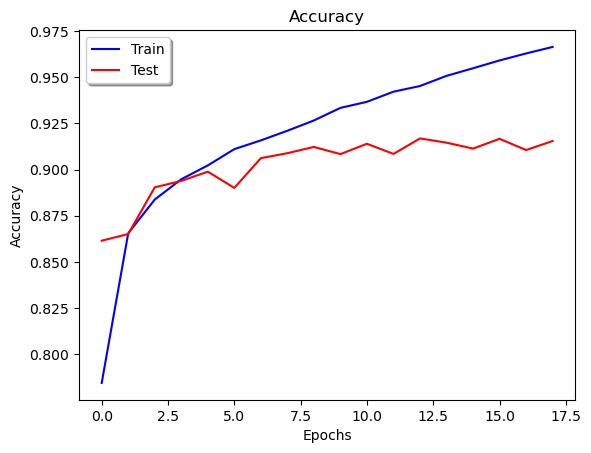

In [ ]:
# Plotting the accuracy
plt.plot(history.history['accuracy'], color='b', label="Train")
plt.plot(history.history['val_accuracy'], color='r', label="Test")
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best', shadow=True)
plt.show()